# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

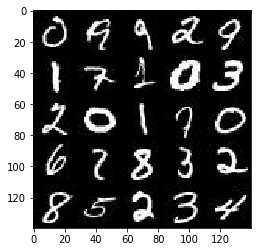

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

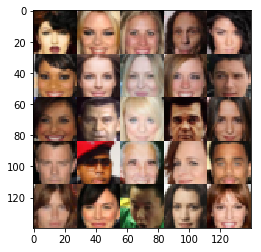

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [6]:
mnist_images.shape

(25, 28, 28, 3)

In [7]:
mnist_images.shape[-3:]

(28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    #input dim will be that of generator output dim, i.e, 28x28xout_chan_dim(3)
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv layer1
        x1 = tf.layers.conv2d(images,64, (5,5), strides=(2,2), padding='same')
        #bn1 = tf.layers.batch_normalization(x1, training=True)
        #commenting out the above batch normalization mistake (and below line), since Ian goodwell's lecture says not to do.
        #relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        #conv layer2
        x2 = tf.layers.conv2d(relu1, 128, (5,5), strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
         #conv layer3
        x3 = tf.layers.conv2d(relu2, 256, (5,5), strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        #flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Input
        x1 = tf.layers.dense(z, 7*7*512)
        # reshape it 
        reshaped1 = tf.reshape(x1, (-1,7,7,512))
        bn1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512 is the output (chngd frm 128)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x128
        
        #logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=(1,1), padding='same')
        # should be 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_out = generator(z=input_z, out_channel_dim=out_channel_dim, is_train=True)
    discriminator_out_real, discriminator_logits_real = discriminator(images=input_real, reuse=False)
    discriminator_out_z, discriminator_logits_z = discriminator(images = generator_out, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_out_real)*0.9))
    
    discriminator_loss_z = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels = tf.zeros_like(discriminator_out_z)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels=tf.ones_like(discriminator_out_z)))
    
    discriminator_loss_total = discriminator_loss_real + discriminator_loss_z
    
    return discriminator_loss_total, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_variables = tf.trainable_variables()
    discriminator_variables = [var for var in t_variables if var.name.startswith('discriminator')]
    generator_variables = [var for var in t_variables if var.name.startswith('generator')]
    
    #optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    losses = []
    steps = 0
    print_every=10
    show_every=100
    
    image_width, image_height, image_channel_depth  = data_shape[-3:]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channel_depth, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z,out_channel_dim=image_channel_depth)
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr, beta1=beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                #random noise sample
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                for i in range(5):
                    _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                #print stats
                if steps % print_every ==0:
                    disc_loss_train = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    gen_loss_train = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(disc_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                    losses.append((disc_loss_train, gen_loss_train))
                    
                #show images
                if steps% show_every ==0:
                    show_generator_output(sess, 16, input_z, image_channel_depth, data_image_mode)
        
        #each epoch
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.0149... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 2.5672... Generator Loss: 0.4653
Epoch 1/2... Discriminator Loss: 1.7843... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.8028... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.9726... Generator Loss: 0.2308
Epoch 1/2... Discriminator Loss: 1.7860... Generator Loss: 0.2882
Epoch 1/2... Discriminator Loss: 1.5795... Generator Loss: 2.6139
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.5170... Generator Loss: 0.6930


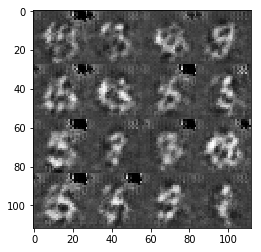

Epoch 1/2... Discriminator Loss: 1.9602... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 2.5962... Generator Loss: 0.1336
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 1.6762
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 1.5832
Epoch 1/2... Discriminator Loss: 1.6390... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.2424
Epoch 1/2... Discriminator Loss: 2.5835... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.7036


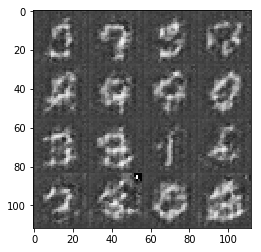

Epoch 1/2... Discriminator Loss: 1.9233... Generator Loss: 0.2564
Epoch 1/2... Discriminator Loss: 2.1654... Generator Loss: 0.2001
Epoch 1/2... Discriminator Loss: 1.6553... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.6680
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.8310... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 1.1100
Epoch 1/2... Discriminator Loss: 1.6349... Generator Loss: 2.6001


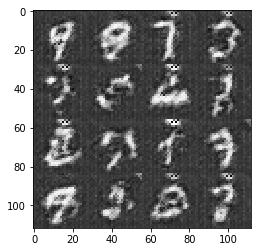

Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.6482
Epoch 1/2... Discriminator Loss: 1.6133... Generator Loss: 0.5040
Epoch 1/2... Discriminator Loss: 2.0878... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 1.6590... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 1.7999... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.7751... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.7843


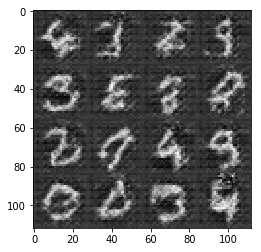

Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.6896
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.7847
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 1.7609... Generator Loss: 0.3358
Epoch 2/2... Discriminator Loss: 1.6871... Generator Loss: 0.3742
Epoch 2/2... Discriminator Loss: 1.9495... Generator Loss: 0.2413
Epoch 2/2... Discriminator Loss: 2.2694... Generator Loss: 0.1650
Epoch 2/2... Discriminator Loss: 1.5324... Generator Loss: 0.6402


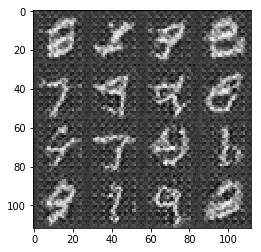

Epoch 2/2... Discriminator Loss: 1.4832... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 1.4322... Generator Loss: 0.6828
Epoch 2/2... Discriminator Loss: 2.0854... Generator Loss: 0.2091
Epoch 2/2... Discriminator Loss: 1.7275... Generator Loss: 0.3739
Epoch 2/2... Discriminator Loss: 2.1304... Generator Loss: 0.2009
Epoch 2/2... Discriminator Loss: 1.3982... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.5545... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8885


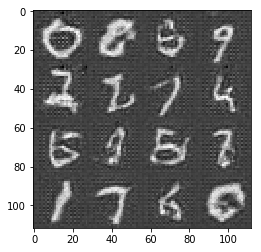

Epoch 2/2... Discriminator Loss: 1.5698... Generator Loss: 0.4873
Epoch 2/2... Discriminator Loss: 1.5471... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 2.2338... Generator Loss: 0.1780
Epoch 2/2... Discriminator Loss: 2.3031... Generator Loss: 0.1669
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.5046
Epoch 2/2... Discriminator Loss: 4.4369... Generator Loss: 2.9744
Epoch 2/2... Discriminator Loss: 1.5257... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.6952
Epoch 2/2... Discriminator Loss: 1.5060... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.9329... Generator Loss: 0.2464


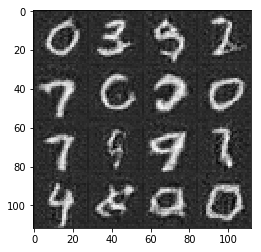

Epoch 2/2... Discriminator Loss: 2.7207... Generator Loss: 0.1030
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.7601
Epoch 2/2... Discriminator Loss: 1.5187... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.5467... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 1.5401... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.6449... Generator Loss: 0.4627
Epoch 2/2... Discriminator Loss: 1.7148... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 1.4867... Generator Loss: 0.5517


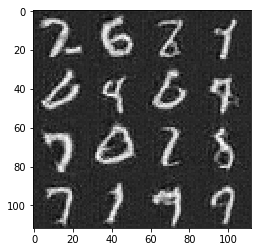

Epoch 2/2... Discriminator Loss: 2.1249... Generator Loss: 0.2090
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.8259
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.5896
Epoch 2/2... Discriminator Loss: 1.9472... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 1.5032... Generator Loss: 0.7124
Epoch 2/2... Discriminator Loss: 2.1516... Generator Loss: 0.2061
Epoch 2/2... Discriminator Loss: 1.9451... Generator Loss: 0.2611


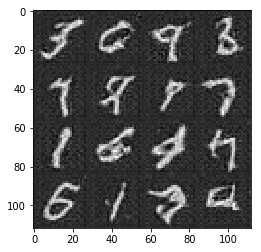

Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.6687... Generator Loss: 0.3705
Epoch 2/2... Discriminator Loss: 1.7303... Generator Loss: 1.4239


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6998... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 2.4810... Generator Loss: 0.2334
Epoch 1/1... Discriminator Loss: 1.9639... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 2.7650
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 2.2357... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 3.7375... Generator Loss: 0.0470
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0310


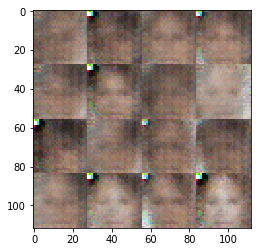

Epoch 1/1... Discriminator Loss: 2.4528... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.9787... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 1.0124


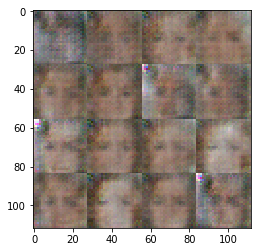

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.9127... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.7562


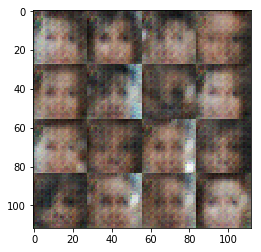

Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.7822


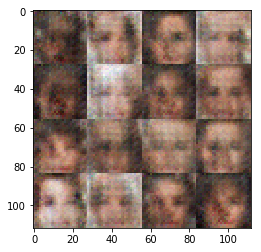

Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7443


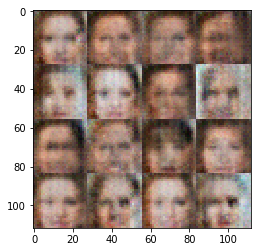

Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7748


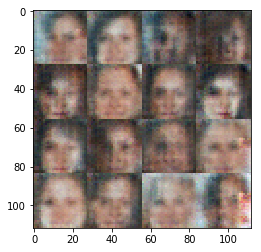

Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6651


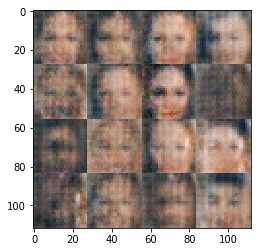

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.6999


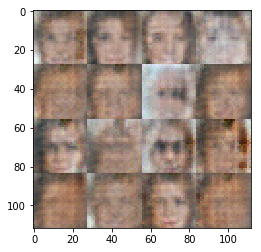

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6751


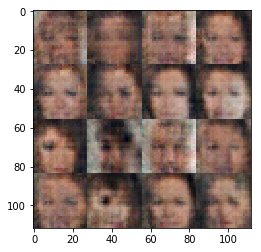

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.6232


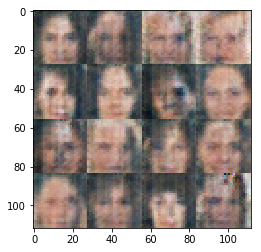

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7557


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.